In [1]:
!pip install langchain langgraph cassio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.3 MB/s eta 0:00:00


In [2]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:UNWYdZlmbZbpnjGbZfDSxHZc:d53f7291cc7e0e3637fe0634e93013c1a3fd86cdd6d3d69f26dcc174758f633f" # enter the "AstraCS:..." string found in in your Token JSON file"
ASTRA_DB_ID="6fa40571-9a01-4d1b-9a9a-f4a209c226c9"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [2]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00


In [1]:
!pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [3]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [6]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [7]:
retriever=astra_vector_store.as_retriever()

In [8]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='007bdb828caf4c30b3b9384cfdfb3e09', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [9]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )



from langchain_groq import ChatGroq
import os

groq_api_key = "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" # Replace with your actual key
print(groq_api_key)
os.environ["GROQ_API_KEY"] = groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Messi?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


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
datasource='wiki_search'
datasource='vectorstore'


In [10]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )



from langchain_groq import ChatGroq
import os

# Use os.getenv to safely get the API key, although it's defined directly here.
# In a real application, store keys securely and use environment variables.
groq_api_key = "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" # Replace with your actual key
print(groq_api_key)
os.environ["GROQ_API_KEY"] = groq_api_key # Ensure the environment variable is set

# Initialize the ChatGroq model with the API key and model name
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

# Bind the structured output to the LLM for routing
structured_llm_router = llm.with_structured_output(RouteQuery)

# Define the system prompt for the router
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

# Create the chat prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Create the routing chain
question_router = route_prompt | structured_llm_router

# Invoke the router with example questions.
# This is the point where the 503 error occurred,
# indicating a temporary issue with the Groq service.
# Re-running this cell or waiting a short while and retrying might resolve it.
print(
    question_router.invoke(
        {"question": "who is Messi?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

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
datasource='wiki_search'
datasource='vectorstore'


In [11]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )



from langchain_groq import ChatGroq
import os

# Use os.getenv to safely get the API key, although it's defined directly here.
# In a real application, store keys securely and use environment variables.
groq_api_key = "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" # Replace with your actual key
print(groq_api_key)
os.environ["GROQ_API_KEY"] = groq_api_key # Ensure the environment variable is set

# Initialize the ChatGroq model with the API key and model name
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

# Bind the structured output to the LLM for routing
structured_llm_router = llm.with_structured_output(RouteQuery)

# Define the system prompt for the router
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

# Create the chat prompt template
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Create the routing chain
question_router = route_prompt | structured_llm_router

# Invoke the router with example questions.
# This is the point where the 503 error occurred,
# indicating a temporary issue with the Groq service.
# Re-running this cell or waiting a short while and retrying might resolve it.
print(
    question_router.invoke(
        {"question": "who is Messi?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

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
datasource='wiki_search'
datasource='vectorstore'


In [12]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

In [16]:
# LLM with function call
from langchain_groq import ChatGroq
import os

groq_api_key = "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" # Replace with your actual key
print(groq_api_key)
os.environ["GROQ_API_KEY"] = groq_api_key

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


In [17]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

In [32]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}

In [13]:
!pip install langchain_community
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=3218e2b8868bc89e2f974d8197cf663153d326f12565ac84381576403b4b2077
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=92509e9bc142ab1e7fe9c1448a126f626a709366678c88d7988ddc605fd6aef5
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built wikipedia sgmllib3k


In [14]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [15]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [34]:
from langchain.schema import Document


def retrieve(state):
    print("---RETRIEVE OR FETCH---")
    question = state["question"]

    # Use your custom retrieval logic
    documents = retrieve_or_fetch(question)
    return {"documents": documents, "question": question}

In [58]:
from datetime import datetime
def wiki_search(state):
    print("---WIKIPEDIA SEARCH---")
    question = state["question"]

    # First try AstraDB again
    vector_results = retriever.get_relevant_documents(question)
    vector_results = [
        doc for doc in vector_results if question.lower() in doc.page_content.lower()
    ]
    if vector_results:
        print("Found in AstraDB on second check.")
        return {"documents": vector_results, "question": question}

    # If not found, query Wikipedia
    docs = wiki.invoke({"query": question})

    if isinstance(docs, str):
        wiki_result = docs
    elif isinstance(docs, list):
        wiki_result = "\n\n".join([doc.page_content for doc in docs])
    else:
        wiki_result = str(docs)

    print("Fetched from Wikipedia")

    wiki_doc = Document(
        page_content=wiki_result,
        metadata={
            "source": "Wikipedia",
            "query": question,
            "timestamp": datetime.utcnow().isoformat()
        }
    )

    astra_vector_store.add_documents([wiki_doc])
    print("Stored Wikipedia result in AstraDB")

    return {"documents": [wiki_doc], "question": question}

### Edges ###

In [59]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION ---")
        return "vectorstore"

In [28]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION ---")
        return "vectorstore"

In [60]:
from langchain.vectorstores.cassandra import Cassandra
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.llms import HuggingFaceHub
from cassio.config import init
from datetime import datetime

# STEP 1: AstraDB credentials
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:UNWYdZlmbZbpnjGbZfDSxHZc:d53f7291cc7e0e3637fe0634e93013c1a3fd86cdd6d3d69f26dcc174758f633f"
ASTRA_DB_ID = "6fa40571-9a01-4d1b-9a9a-f4a209c226c9"

# STEP 2: Initialize Cassio (Astra connection)
init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

# STEP 3: Use correct embedding model (384 dimensions)
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

In [61]:

# STEP 4: Setup vector store
vectorstore = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",             # Make sure this table is created in AstraDB
     # Replace if you use custom keyspace
)

# STEP 5: Define fetch/store logic
def retrieve_or_fetch(query: str):
    print("🧠 Query:", query)
    existing_docs = vectorstore.similarity_search(query, k=1)

    if existing_docs and existing_docs[0].page_content.strip():
        print("✅ Retrieved from AstraDB")
        return existing_docs

    print("---WIKIPEDIA SEARCH---")
    from langchain.utilities import WikipediaAPIWrapper
    wiki = WikipediaAPIWrapper(top_k_results=2)
    wiki_docs = wiki.run(query)

    doc = Document(
        page_content=wiki_docs,
        metadata={
            "source": "Wikipedia",
            "query": query,
            "timestamp": str(datetime.utcnow())
        }
    )

    vectorstore.add_documents([doc])
    print("✅ Wikipedia result stored in AstraDB.")
    return [doc]


In [62]:
from langchain.schema import Document

def vectorstore_node(state):
    """
    AstraDB search node using retrieve_or_fetch
    """
    print("---ASTRA VECTORSTORE SEARCH---")
    question = state["question"]

    # Your custom retrieve_or_fetch logic goes here
    documents = retrieve_or_fetch(question)

    return {
        "documents": documents,
        "question": question
    }


In [63]:
from langgraph.graph import END, StateGraph, START

# Initialize the graph with GraphState
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("wiki_search", wiki_search)         # Node for Wikipedia search
workflow.add_node("vectorstore", vectorstore_node)    # Node for vector DB search

# Conditional routing from START to either wiki_search or vectorstore
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "vectorstore",
    },
)

# Connect nodes to END
workflow.add_edge("wiki_search", END)
workflow.add_edge("vectorstore", END)

# Compile the graph into an app
app = workflow.compile()


In [64]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

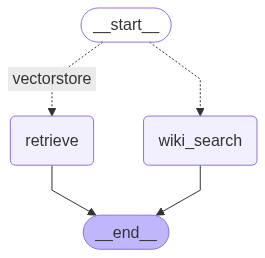

In [65]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [66]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---


---ROUTE QUESTION ---
---RETRIEVE OR FETCH---
🧠 Query: What is agent?
✅ Retrieved from AstraDB
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby imp

<ipython-input-66-a4ba987db3a3>:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [76]:
from langchain.vectorstores.cassandra import Cassandra
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.llms import HuggingFaceHub
from cassio.config import init
from datetime import datetime

# STEP 1: AstraDB credentials
ASTRA_DB_APPLICATION_TOKEN = "AstraCS:UNWYdZlmbZbpnjGbZfDSxHZc:d53f7291cc7e0e3637fe0634e93013c1a3fd86cdd6d3d69f26dcc174758f633f"
ASTRA_DB_ID = "6fa40571-9a01-4d1b-9a9a-f4a209c226c9"

# STEP 2: Initialize Cassio (Astra connection)
init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

# STEP 3: Use correct embedding model (384 dimensions)
embedding = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# STEP 4: Setup vector store
vectorstore = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",             # Make sure this table is created in AstraDB
     # Replace if you use custom keyspace
)

# STEP 5: Define fetch/store logic
def retrieve_or_fetch(query: str):
    print("🧠 Query:", query)
    existing_docs = vectorstore.similarity_search(query, k=1)

    if existing_docs and existing_docs[0].page_content.strip():
        print("✅ Retrieved from AstraDB")
        return existing_docs

    print("---WIKIPEDIA SEARCH---")
    from langchain.utilities import WikipediaAPIWrapper
    wiki = WikipediaAPIWrapper(top_k_results=2)
    wiki_docs = wiki.run(query)

    doc = Document(
        page_content=wiki_docs,
        metadata={
            "source": "Wikipedia",
            "query": query,
            "timestamp": str(datetime.utcnow())
        }
    )

    vectorstore.add_documents([doc])
    print("✅ Wikipedia result stored in AstraDB.")
    return [doc]

# STEP 6: Test the function
docs = retrieve_or_fetch("Pakistan-India War")
for d in docs:
    print("\n📄", d.page_content[:500])

🧠 Query: Pakistan-India War


✅ Retrieved from AstraDB

📄 Page: Indo-Pakistani wars and conflicts
Summary: Since the partition of British India in 1947 and subsequent creation of the dominions of India and Pakistan, the two countries have been involved in a number of wars, conflicts, and military standoffs. A long-running dispute over Kashmir and cross-border terrorism have been the predominant cause of conflict between the two states, with the exception of the Indo-Pakistani War of 1971, which occurred as a direct result of hostilities stemming from t


In [77]:

# STEP 6: Test the function
docs = retrieve_or_fetch("What is an agent")
for d in docs:
    print("\n📄", d.page_content[:500])

🧠 Query: What is an agent
✅ Retrieved from AstraDB

📄 Planning is essentially in order to optimize believability at the moment vs in time.
Prompt template: {Intro of an agent X}. Here is X's plan today in broad strokes: 1)
Relationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.
Environment information is present in a tree structure.




Fig. 13. The generative agent architecture. (Image source: Park et al. 2023)
This fun simulation results in emergent social behavior, such as


In [75]:
from pprint import pprint

# Run
inputs = {
    "question": "who is shahrukh khan"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---


---ROUTE QUESTION TO Wiki SEARCH---
---WIKIPEDIA SEARCH---
Fetched from Wikipedia
Stored Wikipedia result in AstraDB
"Node 'wiki_search':"
'\n---\n'
[Document(metadata={'source': 'Wikipedia', 'query': 'who is shahrukh khan', 'timestamp': '2025-05-16T05:01:43.845493'}, page_content='Page: Shahrukh Khan (cricketer)\nSummary: Masood Shahrukh Khan (born 27 May 1995) is an Indian cricketer who plays as an Batter for Tamil Nadu in domestic cricket. He is a right-handed batter and an of')]


In [73]:
import gradio as gr
from pprint import pprint

def get_documents(question):
    inputs = {"question": question}
    final_docs = None

    for output in app.stream(inputs):
        for key, value in output.items():
            # Optional: print node trace
            print(f"Node '{key}':")
            # You can uncomment below to debug intermediate values
            # pprint(value["keys"], indent=2, width=80, depth=None)
            final_docs = value['documents']  # Capture the final value

    return final_docs  # Return to display in Gradio

# Gradio Interface
iface = gr.Interface(
    fn=get_documents,
    inputs=gr.Textbox(label="Ask a question"),
    outputs=gr.JSON(label="Retrieved Documents"),
    title="Document Retriever",
    description="Enter a question to retrieve related documents."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://42256ce543b56b5f9b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [78]:
import gradio as gr

def get_docs_preview(question):
    docs = retrieve_or_fetch(question)

    # Show up to 500 characters of each doc
    formatted = []
    for i, doc in enumerate(docs, 1):
        content = doc.page_content[:500] if hasattr(doc, "page_content") else str(doc)[:500]
        formatted.append(f"📄 **Document {i}:**\n{content}")

    return "\n\n---\n\n".join(formatted)

# Gradio Interface
iface = gr.Interface(
    fn=get_docs_preview,
    inputs=gr.Textbox(label="Ask a Question"),
    outputs=gr.Markdown(label="Top Retrieved Documents"),
    title="Document Preview Viewer",
    description="Enter a question to view the top document snippets."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8be9b759a99f8fc941.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [74]:
import gradio as gr
from pprint import pprint

def get_documents(question):
    inputs = {"question": question}
    final_docs = []

    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Node '{key}':")
            # pprint(value["keys"], indent=2)
            final_docs = value['documents']  # Extract final documents

    # Format documents to include content and source
    formatted = []
    for doc in final_docs:
        content = doc.get("content", "No content")
        source = doc.get("source", "Unknown source")
        formatted.append(f"📝 **Content:** {content}\n🔗 **Source:** {source}")

    return "\n\n---\n\n".join(formatted)

# Gradio Interface
iface = gr.Interface(
    fn=get_documents,
    inputs=gr.Textbox(label="Ask a question"),
    outputs=gr.Markdown(label="Retrieved Documents with Sources"),
    title="Document Retriever with Sources",
    description="Ask a question to see the retrieved documents and their sources."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://74308ba430445e4ce1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [37]:
# ✅ Step 1: Install Gradio (only needs to be run once)
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 95.1 MB/s eta 0:00:00


In [43]:
def query_router(question):
    inputs = {"question": question + "\n\nPlease provide a detailed and comprehensive answer."}
    final_output = ""
    source_used = ""

    for output in app.stream(inputs):
        for key, value in output.items():
            if key == "wiki_search":
                source_used = "Source: Wikipedia"
                if isinstance(value['documents'], list) and len(value['documents']) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in value['documents']])
                else:
                    final_output = value['documents'].page_content

            elif key == "retrieve":
                source_used = "Source: AstraDB (Vector Store)"
                if isinstance(value['documents'], list) and len(value['documents']) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in value['documents']])
                else:
                    final_output = value['documents'].page_content

    return f"{source_used}\n\n{final_output}"

In [68]:

# --- Updated query_router function ---
def query_router(question):
    """
    Routes the question to the appropriate node and returns the result,
    indicating the source (cached AstraDB result or Wikipedia search).

    This function works over the graph which routes either:
      - "retrieve": when the result is already in AstraDB (vectorstore)
      - "wiki_search": when it needed to be fetched (and stored) from Wikipedia
    """
    inputs = {"question": question + "\n\nPlease provide a detailed and comprehensive answer."}
    final_output = ""
    source_used = ""

    # Stream the outputs from the LangGraph pipeline (which includes routing)
    # In your graph, ensure that when a wiki_search path is taken, it executes the above wiki_search function.
    for output in app.stream(inputs):
        for key, value in output.items():
            # When the graph route returns "wiki_search", it means the wiki_search node was executed
            if key == "wiki_search":
                source_used = "Source: Wikipedia (fetched and stored in AstraDB)"
                if isinstance(value['documents'], list) and len(value['documents']) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in value['documents']])
                else:
                    final_output = value['documents'].page_content

            # The "retrieve" key is used if the answer was already present in AstraDB
            elif key == "retrieve":
                source_used = "Source: AstraDB (Vector Store)"
                if isinstance(value['documents'], list) and len(value['documents']) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in value['documents']])
                else:
                    final_output = value['documents'].page_content

    return f"{source_used}\n\n{final_output}"

In [54]:
def query_router(question):
    """
    Routes the question through LangGraph and prints the final answer
    from either AstraDB or Wikipedia with proper source identification.
    """
    inputs = {
        "question": question + "\n\nPlease provide a detailed and comprehensive answer."
    }

    final_output = ""
    source_used = ""

    for output in app.stream(inputs):
        for key, value in output.items():
            if key == "wiki_search":
                source_used = "📚 Source: Wikipedia (fetched and stored in AstraDB)"
                docs = value.get("documents", [])
                if isinstance(docs, list):
                    if docs and isinstance(docs[0], Document):
                        final_output = "\n\n".join([doc.page_content for doc in docs])
                    else:
                        final_output = "No good Wikipedia Search Result was found."
                else:
                    final_output = docs.page_content if hasattr(docs, "page_content") else str(docs)

            elif key == "retrieve":
                source_used = "📦 Source: AstraDB (Vector Store)"
                docs = value.get("documents", [])
                if isinstance(docs, list):
                    final_output = "\n\n".join([doc.page_content for doc in docs])
                else:
                    final_output = docs.page_content if hasattr(docs, "page_content") else str(docs)

    return f"{source_used}\n\n{final_output}"


In [70]:
# ✅ Step 2: Wrap the LangGraph logic into a function
def ask_question(question):
    inputs = {"question": question}
    output_text = ""

    for output in app.stream(inputs):
        for key, value in output.items():
            if "documents" in value and value["documents"]:
                try:
                    output_text = value["documents"][0].dict()['metadata'].get('description', 'No description found')
                except:
                    output_text = str(value["documents"][0])
            else:
                output_text = "No documents found."
    return output_text

In [72]:
import gradio as gr

iface = gr.Interface(
    fn=ask_question,
    inputs=gr.Textbox(label="Enter your question"),
    outputs=gr.Textbox(label="Answer"),
    title="LangGraph Query Router",
    description="Ask a question about agents, prompt engineering, or general topics."
)

iface.launch(share=True)  # `share=True` will give you a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e01d18a76ecfacd471.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [51]:
def query_router(question):
    """
    Routes the question to the appropriate node and returns the result,
    indicating the source (cached AstraDB result or Wikipedia search).
    """
    inputs = {"question": question + "\n\nPlease provide a detailed and comprehensive answer."}
    final_output = ""
    source_used = ""

    for output in app.stream(inputs):
        for key, value in output.items():
            # --- Handle Wikipedia Search Path ---
            if key == "wiki_search":
                source_used = "📚 Source: Wikipedia (fetched and stored in AstraDB)"
                docs = value.get("documents", [])
                if isinstance(docs, list) and len(docs) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in docs])
                elif isinstance(docs, Document):
                    final_output = docs.page_content
                else:
                    final_output = "⚠️ No Wikipedia result found."

            # --- Handle Retrieval from AstraDB ---
            elif key == "retrieve":
                source_used = "🧠 Source: AstraDB (Vector Store)"
                docs = value.get("documents", [])
                if isinstance(docs, list) and len(docs) > 0:
                    final_output = "\n\n".join([doc.page_content for doc in docs])
                elif isinstance(docs, Document):
                    final_output = docs.page_content
                else:
                    final_output = "⚠️ No stored result found."

    return f"{source_used}\n\n{final_output}"


In [52]:
print(query_router("Who is Shahrukh Khan?"))

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Who is Shahrukh Khan?

Please provide a detailed and comprehensive answer.
📚 Source: Wikipedia (fetched and stored in AstraDB)

No good Wikipedia Search Result was found


In [47]:
def retrieve_or_fetch(query: str):
    print("🧠 Query:", query)

    # Clean the query (remove prompt instructions)
    clean_query = query.split("\n")[0].strip()

    existing_docs = vectorstore.similarity_search(clean_query, k=1)
    if existing_docs and existing_docs[0].page_content.strip():
        print("✅ Retrieved from AstraDB")
        return existing_docs

    print("---WIKIPEDIA SEARCH---")
    from langchain.utilities import WikipediaAPIWrapper
    wiki = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=1000)  # more characters

    try:
        wiki_docs = wiki.run(clean_query)
        if not wiki_docs.strip():
            raise ValueError("No Wikipedia result found.")
    except Exception as e:
        print("❌ Wikipedia Search Failed:", str(e))
        return [Document(page_content="No good Wikipedia Search Result was found")]

    doc = Document(
        page_content=wiki_docs,
        metadata={
            "source": "Wikipedia",
            "query": clean_query,
            "timestamp": str(datetime.utcnow())
        }
    )

    vectorstore.add_documents([doc])
    print("✅ Wikipedia result stored in AstraDB.")
    return [doc]

In [50]:
def wiki_search(state):
    print("---wikipedia---")
    question = state["question"]
    print(question)

    wiki_docs = retrieve_or_fetch(question)

    return {"documents": wiki_docs, "question": question}